# Packages


In [1]:
import pandas as pd
import numpy as np

import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import adfuller


from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from scipy.stats import shapiro, kstest, anderson
from scipy.stats import kendalltau

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
#import functions_module
from functions_module import remove_season, lissage_moyenne_mobile, logit, import_and_series_transformation, highlight_variables, highlight_result, highlight_value, ljung_box, show_acf_pacf, AugmenteDickeyFuller_test, PhillipsPerron_test, kpss_test, drop_trimestrielle_or_annuelle_if_wanted
from functions_module import concat_tests_and_sort, draw_conclusion_stationary, readable_conclusions, newey_west_tests_find_beta, compute_var_lagged, commpute_corr_matrix, choosing_seuil_corr_to_DR, commpute_corr_matrix_var_macro


In [3]:
td = pd.read_excel("data/default_rate_quarterly.xlsx")
macro_adverse = pd.read_excel("data/variables_macroeconomiques_adverse.xlsx")
macro_baseline = pd.read_excel("data/variables_macroeconomiques_baseline.xlsx")

# création du dataframe, avec les variables macro et le TD, index par la date
td = td.set_index("Date")
macro_adverse = macro_adverse.set_index("Date")
macro_adverse["td"]=td

# Variation mensuelle
macro_adverse[['RGDP_tri', 'HICP_tri', 'IRLT_tri',  'RREP_tri', 'UNR_tri']] = (macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']] - macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(1)) / macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(1)
# Variation annuelle
macro_adverse[['RGDP_ann', 'HICP_ann', 'IRLT_ann',  'RREP_ann', 'UNR_ann']] = (macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']] - macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(4)) / macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(4)
# retirons les variables brutes
col_brutes = ['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']
macro_adverse=macro_adverse.drop(col_brutes, axis=1)

macro_lagged_adv = compute_var_lagged(macro_adverse, 2, 5, 1)
macro_lagged_for_model_adv = macro_lagged_adv.copy()

### Pipeline finale pour obternir un dataframe avec les transformations voulues

In [4]:
drop_na = 'Non'
list_col_saison = ['HICP']
list_col_lissage = ['RGDP_ann', 'RGDP_tri']
logit_choix = 'Non'

macro = import_and_series_transformation(drop_na, list_col_saison, list_col_lissage, logit_choix)

In [5]:
types_var_choix = 'toutes' # sinon {'trimestrielle', 'annuelle'}

macro = drop_trimestrielle_or_annuelle_if_wanted(macro, types_var_choix)
np.shape(macro)

(48, 11)

# **Analyses PACF et ACF**



2023-04-05 13:56:16.618 
  command:

    streamlit run c:\Users\arman\miniconda3\envs\creditenv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


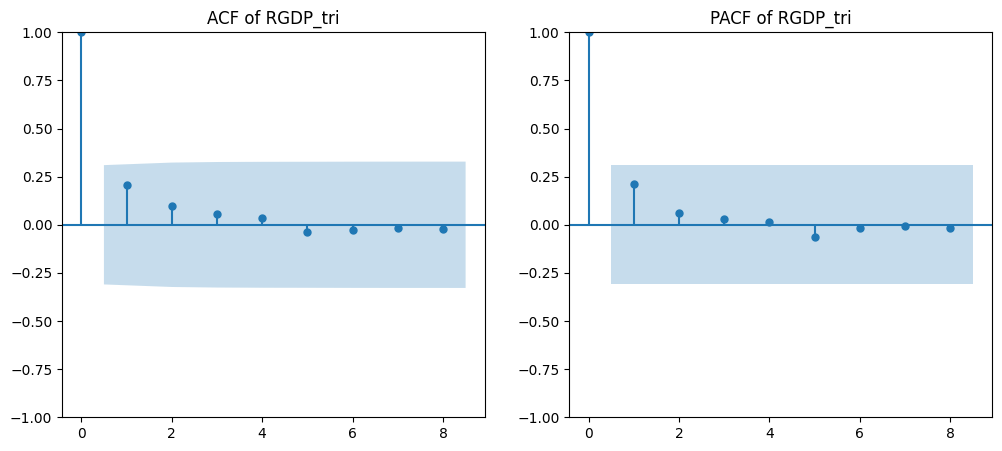

In [6]:
show_acf_pacf(macro, 'RGDP_tri')

**Seul le PIB a l'air presque stationnaire. Mais sinon on détecte des AR(1) souvent**

**Tests de stationnarité** *KPSS and Philips Perron*

# ***Les tests***

**Ljung-Box Test**

We could use to pvalues : Ljung-Box and Box-Pierce. But Ljung-Box and Box-Pierce statistic differ in their scaling of the autocorrelation function. Ljung-Box test is has better finite-sample properties. Ljung-Box is best in our case

In [7]:
drop_td='Yes'
results_Ljung_box = ljung_box(macro, drop_td)
results_Ljung_box

,Variable,Ljung-Box Statistic,p-value,Résultat
0,RGDP_tri,0.037419,0.999986,Les résidus sont indépendants
1,HICP_tri,12.404887,0.029642,Les résidus NE sont PAS indépendants : il y a ...
2,IRLT_tri,2.470383,0.780949,Les résidus sont indépendants
3,RREP_tri,11.092339,0.049580,Les résidus NE sont PAS indépendants : il y a ...
4,UNR_tri,0.400435,0.995318,Les résidus sont indépendants
5,RGDP_ann,0.370254,0.996109,Les résidus sont indépendants
6,HICP_ann,7.020063,0.219152,Les résidus sont indépendants
7,IRLT_ann,5.291310,0.381372,Les résidus sont indépendants
8,RREP_ann,11.146938,0.048543,Les résidus NE sont PAS indépendants : il y a ...
9,UNR_ann,4.347762,0.500507,Les résidus sont indépendants


***KPSS*** 

Taking the null hypothesis as a stationary process and the unit
root as an alternative is in accordance with a conservative testing strategy. If we then reject the null hypothesis, we can
be pretty confident that the series indeed has a unit root. (Plaff, 2008)

In [8]:
# fixons les types de regressions qu'on veut tester pendant la stationnarité
regression_type_kpss = 'c' # peut être {'c', 'ct', 'c_et_ct'} 

if regression_type_kpss == 'c':
    results_kpss = kpss_test(macro.drop('td', axis=1).dropna(), regression='c')
elif regression_type_kpss == 'ct':
    results_kpss = kpss_test(macro.drop('td', axis=1).dropna(), regression='ct')
else : # 'c_et_ct'
    results_c = kpss_test(macro.drop('td', axis=1).dropna(), regression='c')
    results_ct = kpss_test(macro.drop('td', axis=1).dropna(), regression='ct')
    results_kpss = pd.concat([results_c, results_ct], ignore_index=True)
results_kpss.style.applymap(highlight_result, subset=['Résultat'])

results_kpss

,Test,Variable,Regression,Test Statistic,p-value,Lags Used,Résultat
0,KPSS,RGDP_tri,c,0.269,0.100,2,Stationnaire
1,KPSS,HICP_tri,c,0.353,0.098,3,Stationnaire
2,KPSS,IRLT_tri,c,0.099,0.100,3,Stationnaire
3,KPSS,RREP_tri,c,0.371,0.090,2,Stationnaire
4,KPSS,UNR_tri,c,0.164,0.100,0,Stationnaire
5,KPSS,RGDP_ann,c,0.208,0.100,3,Stationnaire
6,KPSS,HICP_ann,c,0.445,0.058,4,Stationnaire
7,KPSS,IRLT_ann,c,0.108,0.100,3,Stationnaire
8,KPSS,RREP_ann,c,0.294,0.100,4,Stationnaire
9,KPSS,UNR_ann,c,0.483,0.045,4,Non Stationnaire


***PP*** 

In [9]:
# fixons les types de regressions qu'on veut tester pendant la stationnarité
regression_type_pp = 'n' # peut être {'n', 'c', 'ct', 'n_et_c', 'n_et_ct', 'c_et_ct', 'all'} 

if regression_type_pp == 'n':
    results_pp = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='n')
elif regression_type_pp == 'c':
    results_pp = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='c')
elif regression_type_pp == 'ct':
    results_pp = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='ct')
elif regression_type_pp == 'n_et_c':
    results_n = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='n')
    results_c = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='c')
    results_pp = pd.concat([results_n, results_c], ignore_index=True)
elif regression_type_pp == 'n_et_ct':
    results_n = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='n')
    results_ct = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='ct')
    results_pp = pd.concat([results_n, results_ct], ignore_index=True)
elif regression_type_pp == 'c_et_ct':
    results_c = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='c')
    results_ct = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='ct')
    results_pp = pd.concat([results_c, results_ct], ignore_index=True)
else:
    results_n = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='n')
    results_c = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='c')
    results_ct = PhillipsPerron_test(macro.drop('td', axis=1).dropna(), regression='ct')
    results_pp = pd.concat([results_n, results_c, results_ct], ignore_index=True)
results_pp.style.applymap(highlight_result, subset=['Résultat'])
results_pp

,Test,Variable,Regression,Test Statistic,p-value,Lags Used,Résultat
RGDP_tri,PP,RGDP_tri,n,-4.035,0.000,10,Stationnaire
HICP_tri,PP,HICP_tri,n,-7.429,0.000,10,Stationnaire
IRLT_tri,PP,IRLT_tri,n,-5.183,0.000,10,Stationnaire
RREP_tri,PP,RREP_tri,n,-5.863,0.000,10,Stationnaire
UNR_tri,PP,UNR_tri,n,-8.626,0.000,10,Stationnaire
RGDP_ann,PP,RGDP_ann,n,-3.291,0.001,10,Stationnaire
HICP_ann,PP,HICP_ann,n,-1.445,0.139,10,Non Stationnaire
IRLT_ann,PP,IRLT_ann,n,-2.257,0.023,10,Stationnaire
RREP_ann,PP,RREP_ann,n,-1.383,0.155,10,Non Stationnaire
UNR_ann,PP,UNR_ann,n,-2.363,0.017,10,Stationnaire


***ADF***

In [10]:
# fixons les types de regressions qu'on veut tester pendant la stationnarité
if regression_type_pp == 'n':
    results_adf = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='n')
elif regression_type_pp == 'c':
    results_adf = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='c')
elif regression_type_pp == 'ct':
    results_adf = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='ct')
elif regression_type_pp == 'n_et_c':
    results_n = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='n')
    results_c = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='c')
    results_adf = pd.concat([results_n, results_c], ignore_index=True)
elif regression_type_pp == 'n_et_ct':
    results_n = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='n')
    results_ct = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='ct')
    results_adf = pd.concat([results_n, results_ct], ignore_index=True)
elif regression_type_pp == 'c_et_ct':
    results_c = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='c')
    results_ct = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='ct')
    results_adf = pd.concat([results_c, results_ct], ignore_index=True)
else:
    results_n = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='n')
    results_c = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='c')
    results_ct = AugmenteDickeyFuller_test(macro.drop('td', axis=1).dropna(), regression='ct')
    results_adf = pd.concat([results_n, results_c, results_ct], ignore_index=True)
results_adf.style.applymap(highlight_result, subset=['Résultat'])
results_adf

,Test,Variable,Regression,Test Statistic,p-value,Lags Used,Résultat
RGDP_tri,ADF,RGDP_tri,n,-4.131,0.000,0,Stationnaire
HICP_tri,ADF,HICP_tri,n,-2.462,0.013,1,Stationnaire
IRLT_tri,ADF,IRLT_tri,n,-2.738,0.006,10,Stationnaire
RREP_tri,ADF,RREP_tri,n,-0.995,0.290,7,Non Stationnaire
UNR_tri,ADF,UNR_tri,n,-9.007,0.000,0,Stationnaire
RGDP_ann,ADF,RGDP_ann,n,-3.267,0.001,0,Stationnaire
HICP_ann,ADF,HICP_ann,n,-2.466,0.013,9,Stationnaire
IRLT_ann,ADF,IRLT_ann,n,-2.944,0.003,10,Stationnaire
RREP_ann,ADF,RREP_ann,n,-1.193,0.213,4,Non Stationnaire
UNR_ann,ADF,UNR_ann,n,-1.845,0.062,1,Non Stationnaire


## ***Tous les tests***

In [11]:
resultats_des_tests = concat_tests_and_sort(results_kpss, results_pp, results_adf)
nb_variables_studies = len(resultats_des_tests['Variable'].unique())
conclusions = draw_conclusion_stationary(resultats_des_tests, nb_variables_studies)
conclusions_readable = readable_conclusions(conclusions)
conclusions_readable.style.applymap(highlight_result, subset=['Décision Finale'])
conclusions_readable

,Variable,Proportion de conclusion positive pour la stationnarité (%),Décision Finale
0,HICP_ann,66.67,Stationnaire
1,HICP_tri,100.00,Stationnaire
2,IRLT_ann,100.00,Stationnaire
3,IRLT_tri,100.00,Stationnaire
4,RGDP_ann,100.00,Stationnaire
5,RGDP_tri,100.00,Stationnaire
6,RREP_ann,33.33,Non Stationnaire
7,RREP_tri,66.67,Stationnaire
8,UNR_ann,33.33,Non Stationnaire
9,UNR_tri,100.00,Stationnaire


In [12]:
list_var_stationary = conclusions_readable[conclusions_readable['Décision Finale']=='Stationnaire']['Variable'].unique().tolist()
macro_stationary = macro[list_var_stationary+ ['td']]

# Stationnarité du taux de defaut 

In [13]:
td_serie = pd.DataFrame(macro['td']).dropna()
drop_td='No'
lj_b = ljung_box(td_serie, drop_td)
lj_b

,Variable,Ljung-Box Statistic,p-value,Résultat
0,td,3.879696,0.566864,Les résidus sont indépendants


In [14]:
results_KPSS_c = kpss_test(td_serie, regression='c')
results_PP_c = PhillipsPerron_test(td_serie,  regression='c')
results_ADF_c = AugmenteDickeyFuller_test(td_serie, regression='c')
results_DR = pd.concat([results_KPSS_c, results_PP_c, results_ADF_c], ignore_index=True)
results_DR.style.applymap(highlight_result, subset=['Résultat'])

,Test,Variable,Regression,Test Statistic,p-value,Lags Used,Résultat
0,KPSS,td,c,0.765000,0.010000,4,Non Stationnaire
1,PP,td,c,-1.741000,0.410000,10,Non Stationnaire
2,ADF,td,c,-1.700000,0.431000,0,Non Stationnaire


In [15]:
kpss_beta = newey_west_tests_find_beta(macro, 'KPSS')
pp_beta = newey_west_tests_find_beta(macro, 'PP')
adf_beta = newey_west_tests_find_beta(macro, 'ADF')
    

In [16]:
values_adf = np.array(adf_beta[adf_beta['crit'] > adf_beta['stat']]['betax'])
values_kpss = np.array(kpss_beta[kpss_beta['crit'] > kpss_beta['stat']]['betax'])
values_pp = np.array(pp_beta[pp_beta['crit'] > pp_beta['stat']]['betax'])

# Inner join sur les deux arrays : car on veut garder les valeurs de beta pour lesquellesles deux tests expriment la stationnarité
values_available_for_beta = np.intersect1d(values_kpss, values_pp)
values_available_for_beta = np.intersect1d(values_available_for_beta, values_adf)

if not len(values_available_for_beta) == 0:
    print(values_available_for_beta)
else:
    print('Aucun Beta disponible, les tests sont trop restrictifs')


Aucun Beta disponible, les tests sont trop restrictifs


#  Creation de toutes les varaibles avec les lags, en retire les variables non stationnaires

# ***Corrélation entre les variables macro et le taux de défaut***

On ne peut pas utiliser Pearson à cause du nombre d'observations beaucoup trop faible. Le tau de Kendall est adapté à la taille de l'échantillon en revanche (Approche Non-Parametrique).

#### En calculant des Variables laggées, je crée plusieurs valeurs manquantes en début de séries. Au maximum j'en crée 5. Pour les variables avec les variations annuelles, avec un lag de 5, j'obtiens 10 valeurs manquantes en tout début de période. Je préfère calculer deux lag pour les variables de variations annuelles, ca permet de ne perdre que 6 observations en début de période

In [54]:
# Avec : macro_stationary
number_lag_ann = 2
number_lag_tri = 5
number_lag_td = 1
macro_lagged = compute_var_lagged(macro_stationary, number_lag_ann, number_lag_tri, number_lag_td)
macro_lagged_for_model = macro_lagged.copy()
len(macro_lagged_for_model.columns)

41

In [55]:
corr_df = commpute_corr_matrix(macro_lagged)
# On se focalise sur les correlations concernant le taux de défaut
df_var_corr_to_DR = pd.DataFrame(corr_df['td']).rename(columns={'td': 'Kendall Correlations'}).sort_values(by=['Kendall Correlations']).drop('td',axis=0)
# Peu importe le sens des signes, on cherche surtout à avoir les variables qui sont corrélées avec le taux de défaut : donc on prend la valeur absolue
df_var_corr_to_DR['Kendall Correlations'] = df_var_corr_to_DR['Kendall Correlations'].abs()
df_var_corr_to_DR = df_var_corr_to_DR.sort_values(by=['Kendall Correlations'], ascending=False)

number_threshold = 0.15

list_var_in_model = choosing_seuil_corr_to_DR(df_var_corr_to_DR, number_threshold)
len(list_var_in_model)

20

## OUTPUT DES CORR AVEC TAUX DE DEFAUT = UNE LISTE :

## Correlation des variables(qu'on voudrait garder dans le modèle) : retirer les variables trop corrélées entre elles

In [56]:
list_var_in_model

['td_lag1',
 'RREP_tri_lag1',
 'RREP_tri_lag5',
 'UNR_tri_lag5',
 'RREP_tri',
 'RGDP_ann_lag2',
 'UNR_tri_lag4',
 'RGDP_tri_lag4',
 'RGDP_tri_lag5',
 'IRLT_ann_lag2',
 'UNR_tri_lag3',
 'RREP_tri_lag4',
 'UNR_tri',
 'RGDP_ann_lag1',
 'IRLT_ann_lag1',
 'RGDP_tri_lag3',
 'RREP_tri_lag2',
 'RREP_tri_lag3',
 'UNR_tri_lag1',
 'IRLT_ann']

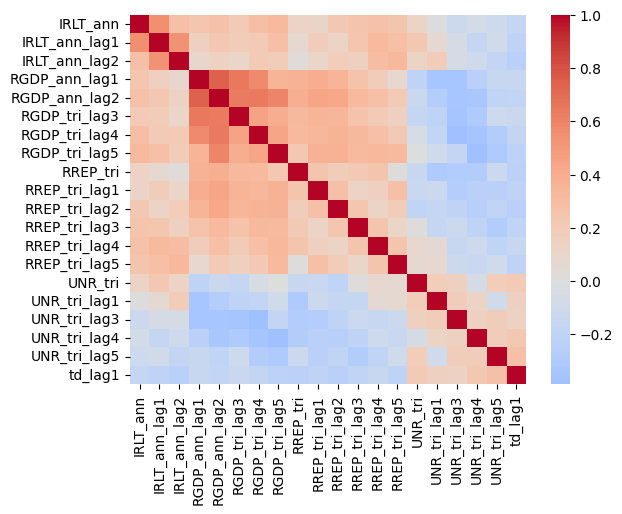

In [57]:
list_var_in_model.sort()
macro_lagged_for_corr = macro_lagged.copy()
corr_df_macro = commpute_corr_matrix_var_macro(macro_lagged, list_var_in_model)
corr_df_for_corr = commpute_corr_matrix_var_macro(macro_lagged_for_corr, list_var_in_model)

sns.heatmap(corr_df_macro.astype(float), cmap='coolwarm', center=0, annot=False)
plt.show()

In [58]:
def find_high_corr_pairs(corr_matrix, threshold):
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
    return high_corr_pairs


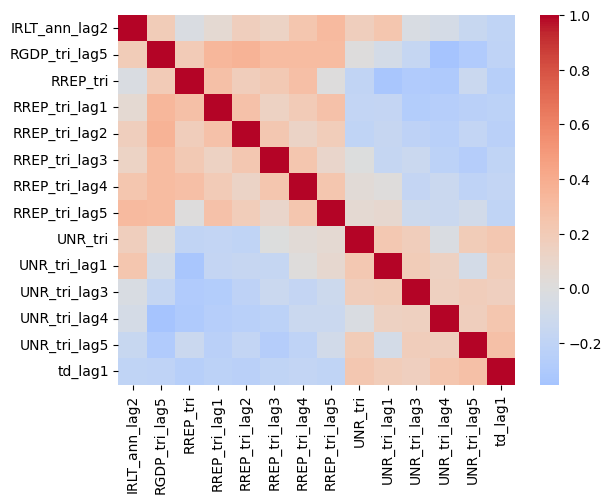

In [59]:
number_seuil = 0.4

first_elements_variables = [t[0] for t in find_high_corr_pairs(corr_df_macro, number_seuil)]
all_elements_variables = list(set(first_elements_variables))

macro_lagged_for_corr = macro_lagged_for_corr[list_var_in_model].drop(all_elements_variables, axis=1)

corr_df_for_corr = commpute_corr_matrix_var_macro(macro_lagged_for_corr, sorted(macro_lagged_for_corr.columns))

sns.heatmap(corr_df_for_corr.astype(float), cmap='coolwarm', center=0, annot=False)
plt.show()

In [60]:
var_to_drop = []
find_high_corr_pairs(macro_lagged_for_corr.drop(var_to_drop, axis=1), 0.4)

[]

In [61]:
for i in range (len(find_high_corr_pairs(corr_df_for_corr, 0.4))):
    try:
        macro_lagged_for_corr = macro_lagged_for_corr.drop(find_high_corr_pairs(corr_df_for_corr, 0.5)[i][0], axis=1)
    except :
        pass

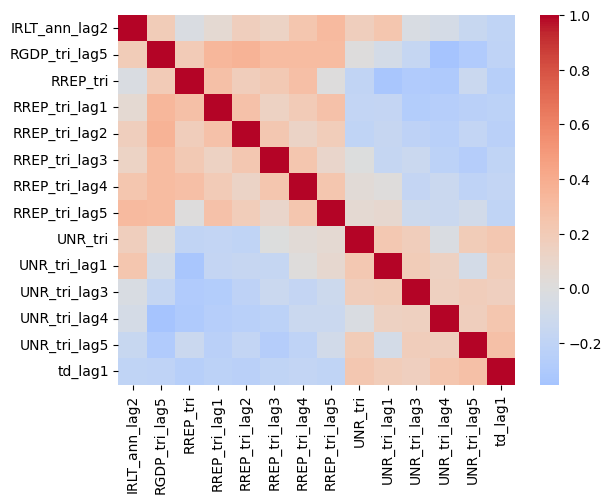

In [62]:
corr_df_for_corr = commpute_corr_matrix_var_macro(macro_lagged_for_corr, macro_lagged_for_corr.columns)
#corr_df_macro

sns.heatmap(corr_df_for_corr.astype(float), cmap='coolwarm', center=0, annot=False)
plt.show()

In [63]:
"""corr_df_for_corr = commpute_corr_matrix_var_macro(macro_lagged_for_corr, macro_lagged_for_corr.columns)
#corr_df_macro

sns.heatmap(corr_df_for_corr.astype(float), cmap='coolwarm', center=0, annot=False)
plt.show()"""

"corr_df_for_corr = commpute_corr_matrix_var_macro(macro_lagged_for_corr, macro_lagged_for_corr.columns)\n#corr_df_macro\n\nsns.heatmap(corr_df_for_corr.astype(float), cmap='coolwarm', center=0, annot=False)\nplt.show()"

In [64]:
macro_lagged_for_corr = macro_lagged[macro_lagged_for_corr.columns.tolist() + ['td']]

In [65]:
len(macro_lagged_for_corr.columns)

15

# UNE AUTRE HISTOIRE... LA MODELISATION

# Modélisation simple

In [66]:
import itertools
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, het_goldfeldquandt
import statsmodels.api as sm
# faut changer les dataframes
adl = macro_lagged_for_corr.copy()
df_lags = macro_lagged_for_corr.copy()

df_lags = df_lags.dropna()
df_lags.columns

Index(['IRLT_ann_lag2', 'RGDP_tri_lag5', 'RREP_tri', 'RREP_tri_lag1',
       'RREP_tri_lag2', 'RREP_tri_lag3', 'RREP_tri_lag4', 'RREP_tri_lag5',
       'UNR_tri', 'UNR_tri_lag1', 'UNR_tri_lag3', 'UNR_tri_lag4',
       'UNR_tri_lag5', 'td_lag1', 'td'],
      dtype='object')

In [67]:
def split_train_test(df):
    df.index = pd.to_datetime(df.index)

    # Get index object
    idx = df.index

    # Define time interval for train and test sets
    train_start_date = datetime.date(2010, 7, 31)
    train_end_date = datetime.date(2018, 10, 31)
    test_start_date = datetime.date(2018, 10, 31)
    test_end_date = datetime.date(2024, 12, 31)

    # Split data into train and test sets based on time interval
    train_data = df[(idx.date >= train_start_date) & (idx.date <= train_end_date)]
    test_data = df[(idx.date > test_start_date) & (idx.date <= test_end_date)]

    # Display train and test set sizes
    print('Train set size:', len(train_data))
    print('Test set size:', len(test_data))

    return train_data, test_data

df_train, df_test = split_train_test(df_lags) #on fait un split : 1 an pour le test, le reste sert à entraîner le modèle

Train set size: 34
Test set size: 4


In [68]:
def model_OLS(df_lags, varaibles_explicatives_allowed):
    y = df_lags["td"]
    X = df_lags[varaibles_explicatives_allowed]
    # Sort columns alphabetically
    sorted_columns = sorted(X.columns)
    # Reindex DataFrame using sorted column names
    X = X[sorted_columns]
    X = sm.add_constant(X)
    df_var = X
    results = sm.OLS(y, X).fit() #toujours mettre une constante dans le modèle

    # Verify the assumptions of normality and multicollinearity
    resid = results.resid
    p_shapiro = shapiro(resid).pvalue
    p_kolmogorov = kstest(resid, 'norm').pvalue
    boolean_anderson = anderson(resid).statistic > anderson(resid).critical_values[2]
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X, i) for i in range(1, X.shape[1])]
    nb_vif_high = (vif['VIF'] > 5).sum()

    # Save the results in the DataFrame
    params_dict = {var + '_param': param for var, param in zip(results.params.index, results.params)}
    #params_dict.pop("const_param", None) #Je veux garder la constante, et connaitre sa valeur
    pvals_dict = {var + '_pval': results.pvalues[i] for i, var in enumerate(results.params.index)}
    pvals_dict.pop("const_pval", None)
    errors_for_theil = (np.sqrt(sum(np.array(y)**2) / len(y))) + (np.sqrt(sum(np.array(results.predict(sm.add_constant(X)))**2) / len(results.predict(sm.add_constant(X)))))

    row = {
            'variables': [results.params.index],
            'bic': results.bic,
            'logv': results.llf,
            'R2' : results.rsquared,
            'R2_aj' : results.rsquared_adj,
            'RMSE' : np.sqrt(results.mse_resid),
            'U de Theil' :  np.sqrt(results.mse_resid)/errors_for_theil,
            'pval_shapiro': p_shapiro,
            'pval_kolmogorov': p_kolmogorov,
            'boolean_anderson': boolean_anderson,
            'mean_resid': resid.mean(),
            'nb_var_vif_above_5': nb_vif_high,
            'nb_vars': X.shape[1] - 1,
            **params_dict,
            **pvals_dict
        }

    # On return un dataframe avec les informations clés du modèle, le modèle lui-même sous forme sm.OLS().fit, la variable cible le dataframe créé de variables explicatives 
    return row, results, y, df_var 

In [69]:
def graphique_periode_entrainement(df, sentence):
    fig = px.scatter(df, x='td', y='td_predicted')

    # Add axis labels and a title
    fig.update_layout(
        xaxis_title='td',
        yaxis_title='td_predicted',
        title="Graphique du dataset d'entrainement"
    )

    # Create a line plot of 'td' vs 'y_pred'
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df['td'], mode='lines', name='td', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=df.index, y=df['td_predicted'], mode='lines', name='td_predicted', line=dict(color='blue')))

    # Add axis labels and a title
    fig.update_layout(
        xaxis_title='Dates',
        yaxis_title='%',
        title="Graphique du dataset d'entrainement en utilisant "+ sentence
    )

    # Display the plot
    fig.show()

def interpretation_tests(df):

    hypothesis = pd.DataFrame(df)[['pval_shapiro',
                'pval_kolmogorov',
                'mean_resid',
                'nb_var_vif_above_5', 
                'boolean_anderson']]
    conclusion_tests_normalite = 0
    if hypothesis['mean_resid'][0]<0.5 :
        print("La moyenne des résidus est très proche de zéro. L'hypothèse faible de normalité des résidus est respectée.")
    else :
        print("La moyenne des résidus est plutôt loin de zéro. L'hypothèse faible de normalité des résidus n'est pas respectée")
    print("-------")
    if hypothesis['pval_shapiro'][0]>0.05:
        print("On ne peut pas dire que les résidus ne suivent pas une loi normale. Donc on accepte l'hypothèse de normalité des résidus")
        conclusion_tests_normalite +=1
    else :
        print("On peut  dire que les résidus ne suivent pas une loi normale. Donc on rejette l'hypothèse de normalité des résidus")
    
    if hypothesis['pval_kolmogorov'][0]>0.05:
        print("On rejette l'hypothèse de normalité (two-sided test).")
    else :
        print("On accepte l'hypothèse de normanité des résidus")
        conclusion_tests_normalite +=1
    if hypothesis['boolean_anderson'][0] == True :
        print("On rejette l'hypothèse H0 du test, donc on rejette la normalité des résidus")
    else:
        print("On accepte l'hypothèse H0 du test, donc on accepte la normalité des résidus")
        conclusion_tests_normalite +=1
    if conclusion_tests_normalite >1 :
        print("{}% des tests de normalité admettent la normalité des résidus, sur 3 tests.".format(round(conclusion_tests_normalite/3*100), 0))
    print("-------")
    print("Le modèle admet {} variables avec un facteur VIF supérieur à 5".format(hypothesis['nb_var_vif_above_5'][0]))

def tests_homoscedasticide(res, endog_var, exog_var):
    pval_breuschpagan = het_breuschpagan(resid=res, exog_het=exog_var)[0]
    pval_white = het_white(resid=res, exog=exog_var)[1]
    pval_goldfeldquandt = het_goldfeldquandt(y=endog_var, x=exog_var)[1]
    print("Pvalue du test Breusch Pagan : ", str(pval_breuschpagan))
    print("Pvalue du test White : ", str(pval_white))
    print("Pvalue du test Goldfeldquandt : ", str(pval_goldfeldquandt))

Estimation du modèle simpliste

In [171]:
df_train_unrealistic = df_train.copy()

variables_kept_unrealistic = list(df_train_unrealistic.columns)
variables_excluded_unrealistic = ['td']    #ajouter des trucs pour donner le choix à l'utilisateur de retirer des varaibles
for variable in variables_excluded_unrealistic:
    variables_kept_unrealistic.remove(variable)
row_unrealistic, results_unrealistic, dr_unrealistic, var_unrealistic = model_OLS(df_train_unrealistic, variables_kept_unrealistic) #modèle de base
df_train_unrealistic['td_predicted'] = results_unrealistic.predict()
#row_unrealistic

In [128]:
#results_unrealistic.summary()

In [129]:

graphique_periode_entrainement(df_train_unrealistic, "le modèle sous-optimal")

In [130]:

interpretation_tests(row_unrealistic)

La moyenne des résidus est très proche de zéro. L'hypothèse faible de normalité des résidus est respectée.
-------
On ne peut pas dire que les résidus ne suivent pas une loi normale. Donc on accepte l'hypothèse de normalité des résidus
On accepte l'hypothèse de normanité des résidus
On accepte l'hypothèse H0 du test, donc on accepte la normalité des résidus
100% des tests de normalité admettent la normalité des résidus, sur 3 tests.
-------
Le modèle admet 8 variables avec un facteur VIF supérieur à 5


In [131]:
fig = px.scatter(x=results_unrealistic.predict(var_unrealistic), y=results_unrealistic.resid, labels={'x': 'Valeurs prédites', 'y': 'Résidus'},
                 title='Graphique de résidus pour montrer l\'homoscédasticité')
fig.add_hline(y=0, line_dash="dot", line_color="red")

fig.show()

Cusum statistic :  0.4927 | p-value :  0.9684


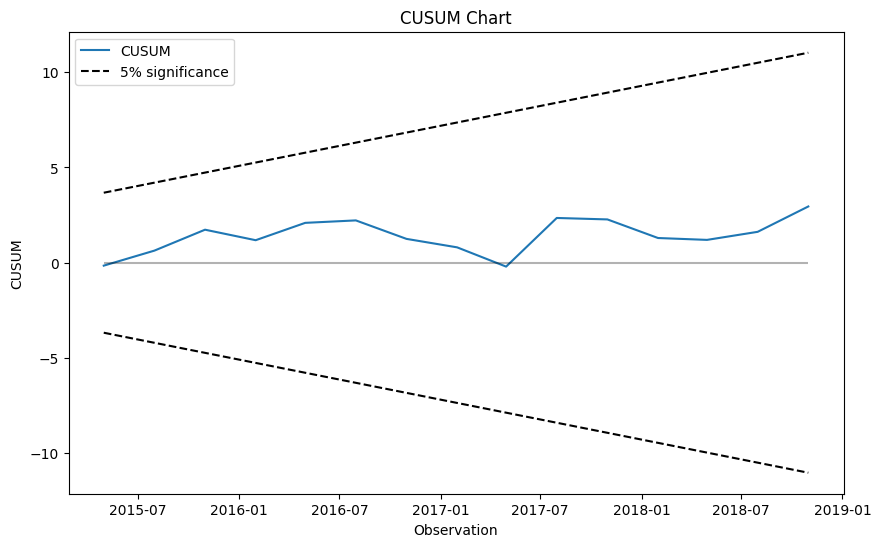

In [132]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid
cusum_test = breaks_cusumolsresid(results_unrealistic.resid)
print("Cusum statistic : ", round(cusum_test[0], 4), "| p-value : ", round(cusum_test[1], 4))

rls_reg = sm.RecursiveLS(pd.DataFrame(dr_unrealistic) , var_unrealistic)
res = rls_reg.fit()
fig = res.plot_cusum(figsize=(10,6))
plt.title('CUSUM Chart')
plt.xlabel('Observation')
plt.ylabel('CUSUM')
plt.show()

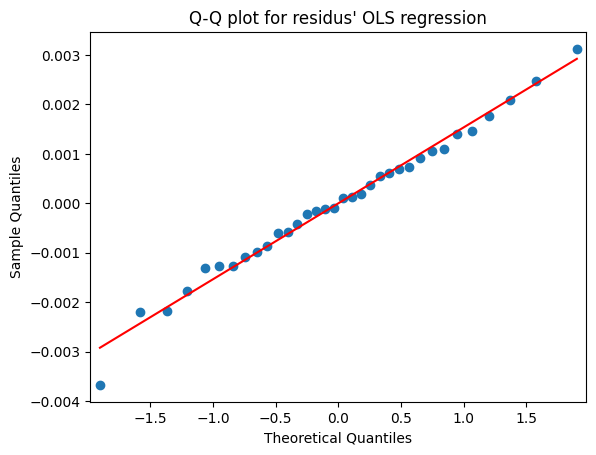

In [133]:
fig = sm.qqplot(results_unrealistic.resid, line = "r")
plt.title("Q-Q plot for residus' OLS regression")
plt.show()

In [134]:

tests_homoscedasticide_unrealistic = tests_homoscedasticide(results_unrealistic.resid, dr_unrealistic,  var_unrealistic)
print(tests_homoscedasticide_unrealistic)

Pvalue du test Breusch Pagan :  19.82725235890753
Pvalue du test White :  0.4192380898312325
Pvalue du test Goldfeldquandt :  nan
None


In [135]:
from scipy.stats import bartlett
bartlett(results_unrealistic.resid)


ValueError: Must enter at least two input sample vectors.

In [136]:
import plotly.graph_objs as go
import plotly.offline as pyo

trace = go.Scatter(x=results_unrealistic.predict(), y=results_unrealistic.resid, mode='markers')
layout = go.Layout(title='Graphique de résidus versus ajustements', xaxis=dict(title='Ajustements'), yaxis=dict(title='Résidus'))
fig = go.Figure(data=[trace], layout=layout)
fig.show()

### LJUNG BOX : LE FAIRE BIEN. BESOIN D Y REFLECHIR AVEC LA TETE FRAICHE 

In [137]:
df_train.columns

Index(['IRLT_ann', 'IRLT_ann_lag1', 'IRLT_ann_lag2', 'RGDP_tri_lag3',
       'RGDP_tri_lag4', 'RGDP_tri_lag5', 'RREP_tri', 'RREP_tri_lag1',
       'RREP_tri_lag2', 'RREP_tri_lag3', 'RREP_tri_lag4', 'RREP_tri_lag5',
       'UNR_tri', 'UNR_tri_lag1', 'UNR_tri_lag3', 'UNR_tri_lag4',
       'UNR_tri_lag5', 'td_lag1', 'td'],
      dtype='object')

Modèle traditionnel : OLS respectueux des hypothèses sur les pvalues

In [138]:

variables_kept_signi = list(df_train.columns)
variables_excluded_signi = ['td', 'UNR_tri_lag5', 'RGDP_tri_lag5', 'UNR_tri', 'RREP_tri', 'RREP_tri_lag4', 'UNR_tri_lag1', 'RGDP_tri_lag3', 
                      'UNR_tri_lag3', 'UNR_tri_lag4', 'RREP_tri_lag3', 'RREP_tri_lag1', 'RREP_tri_lag2']    #ajouter des trucs pour donner le choix à l'utilisateur de retirer des varaibles
for variable in variables_excluded_signi:
    variables_kept_signi.remove(variable)
row_signi, results_signi, dr_signi, var_signi = model_OLS(df_train, variables_kept_signi) 

df_train['td_predicted'] = results_signi.predict()
#row_signi

In [139]:
graphique_periode_entrainement(df_train, "le modèle sous-optimal")

In [140]:
interpretation_tests(row_signi)
fig = px.scatter(x=results_signi.predict(var_signi), y=results_signi.resid, labels={'x': 'Valeurs prédites', 'y': 'Résidus'},
                 title='Graphique de résidus pour montrer l\'homoscédasticité')
fig.add_hline(y=0, line_dash="dot", line_color="red")

fig.show()

La moyenne des résidus est très proche de zéro. L'hypothèse faible de normalité des résidus est respectée.
-------
On ne peut pas dire que les résidus ne suivent pas une loi normale. Donc on accepte l'hypothèse de normalité des résidus
On accepte l'hypothèse de normanité des résidus
On accepte l'hypothèse H0 du test, donc on accepte la normalité des résidus
100% des tests de normalité admettent la normalité des résidus, sur 3 tests.
-------
Le modèle admet 1 variables avec un facteur VIF supérieur à 5


Cusum statistic :  0.7105 | p-value :  0.6937


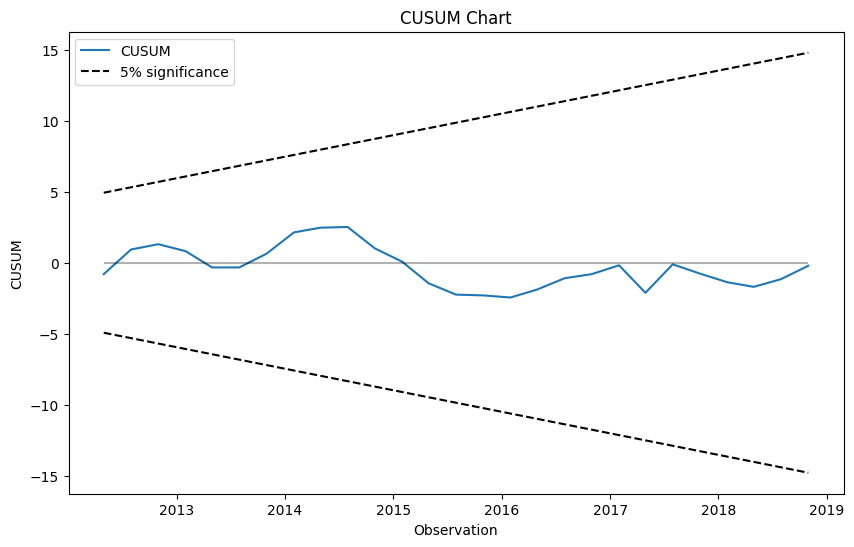

In [141]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid
cusum_test = breaks_cusumolsresid(results_signi.resid)
print("Cusum statistic : ", round(cusum_test[0], 4), "| p-value : ", round(cusum_test[1], 4))

rls_reg = sm.RecursiveLS(pd.DataFrame(dr_signi) , var_signi)
res = rls_reg.fit()
fig = res.plot_cusum(figsize=(10,6))
plt.title('CUSUM Chart')
plt.xlabel('Observation')
plt.ylabel('CUSUM')
plt.show()

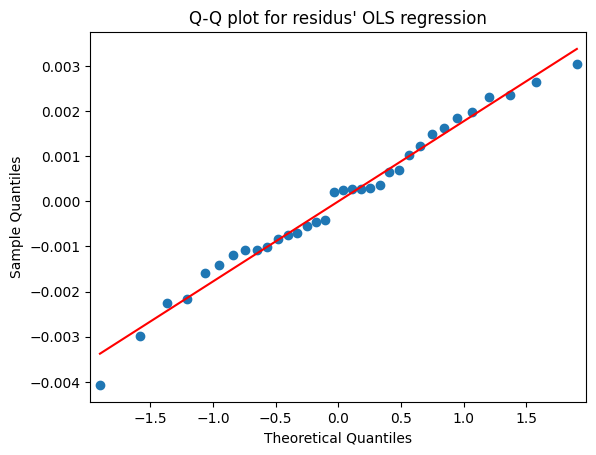

In [142]:
fig = sm.qqplot(results_signi.resid, line = "r")
plt.title("Q-Q plot for residus' OLS regression")
plt.show()

In [143]:

tests_homoscedasticide_unrealistic = tests_homoscedasticide(results_signi.resid, dr_signi,  var_signi)
print(tests_homoscedasticide_unrealistic)

Pvalue du test Breusch Pagan :  12.054584395329142
Pvalue du test White :  0.4228218209393461
Pvalue du test Goldfeldquandt :  0.4993800491481213
None


In [150]:
df_lags.columns

Index(['IRLT_ann', 'IRLT_ann_lag1', 'IRLT_ann_lag2', 'RGDP_tri_lag3',
       'RGDP_tri_lag4', 'RGDP_tri_lag5', 'RREP_tri', 'RREP_tri_lag1',
       'RREP_tri_lag2', 'RREP_tri_lag3', 'RREP_tri_lag4', 'RREP_tri_lag5',
       'UNR_tri', 'UNR_tri_lag1', 'UNR_tri_lag3', 'UNR_tri_lag4',
       'UNR_tri_lag5', 'td_lag1', 'td'],
      dtype='object')

## Utilisation des estimations pour faire les prédictions

#### Preprocessing sur les scénarios

In [145]:
td = pd.read_excel("data/default_rate_quarterly.xlsx")
macro_adverse = pd.read_excel("data/variables_macroeconomiques_adverse.xlsx")
macro_baseline = pd.read_excel("data/variables_macroeconomiques_baseline.xlsx")

# création du dataframe, avec les variables macro et le TD, index par la date
td = td.set_index("Date")
macro_adverse = macro_adverse.set_index("Date")
macro_adverse["td"]=td

# Variation mensuelle
macro_adverse[['RGDP_tri', 'HICP_tri', 'IRLT_tri',  'RREP_tri', 'UNR_tri']] = (macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']] - macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(1)) / macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(1)
# Variation annuelle
macro_adverse[['RGDP_ann', 'HICP_ann', 'IRLT_ann',  'RREP_ann', 'UNR_ann']] = (macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']] - macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(4)) / macro_adverse[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(4)
# retirons les variables brutes
col_brutes = ['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']
macro_adverse=macro_adverse.drop(col_brutes, axis=1)

macro_lagged_adv = compute_var_lagged(macro_adverse, 2, 5, 1)
macro_lagged_for_model_adv = macro_lagged_adv.copy()

macro_lagged_for_model_adv = macro_lagged_for_model_adv[variables_kept_signi]

# Sort columns alphabetically
sorted_columns = sorted(macro_lagged_for_model_adv.columns)
# Reindex DataFrame using sorted column names
macro_lagged_for_model_adv = macro_lagged_for_model_adv[sorted_columns]

macro_lagged_for_model_adv = sm.add_constant(macro_lagged_for_model_adv)

In [146]:
predicted_y = df_train.loc[df_train.index[-1], 'td']

train_end_index = macro_lagged_for_model_adv.index.get_loc(pd.to_datetime('2018-10-31')) #je vais prédire à partir de la fin de l'entrainement
macro_lagged_for_model_adv_loop = macro_lagged_for_model_adv.reset_index(drop = True)
macro_lagged_for_model_adv_loop
adverse_predict = macro_lagged_for_model_adv_loop.copy()


In [147]:
for i in range(train_end_index, len(macro_lagged_for_model_adv_loop)):
    # Add predicted value for previous date to predictors
    macro_lagged_for_model_adv_loop.loc[i, 'td_lag1'] = predicted_y
    
    macro_lagged_for_model_adv_i = macro_lagged_for_model_adv_loop.iloc[[i]]
    # Make prediction for current date
    print(macro_lagged_for_model_adv_i)
    predicted_y_i = results_signi.predict(macro_lagged_for_model_adv_i)
    
    adverse_predict.loc[macro_lagged_for_model_adv_loop.index[i], 'td_predict'] = predicted_y

    # Update predicted value for next date
    predicted_y = predicted_y_i.values[0]



    const  IRLT_ann  IRLT_ann_lag1  IRLT_ann_lag2  RGDP_tri_lag4  \
11    1.0  0.666667       0.594203       0.479821      -0.000171   

    RREP_tri_lag5   td_lag1  
11      -0.004032  0.028087  
    const  IRLT_ann  IRLT_ann_lag1  IRLT_ann_lag2  RGDP_tri_lag4  \
12    1.0  0.121212       0.666667       0.594203      -0.005958   

    RREP_tri_lag5   td_lag1  
12      -0.002024  0.030911  
    const  IRLT_ann  IRLT_ann_lag1  IRLT_ann_lag2  RGDP_tri_lag4  \
13    1.0  0.121212       0.121212       0.666667       0.000733   

    RREP_tri_lag5   td_lag1  
13      -0.067359  0.031655  
    const  IRLT_ann  IRLT_ann_lag1  IRLT_ann_lag2  RGDP_tri_lag4  \
14    1.0  0.121212       0.121212       0.121212       0.003414   

    RREP_tri_lag5   td_lag1  
14      -0.008065  0.043407  
    const  IRLT_ann  IRLT_ann_lag1  IRLT_ann_lag2  RGDP_tri_lag4  \
15    1.0  0.121212       0.121212       0.121212       0.000413   

    RREP_tri_lag5   td_lag1  
15      -0.001016  0.043001  
    const  IRLT

In [152]:
#adverse_predict

# **Bayesian model average - BMA**
***CHANGER LA FONCTION POUR AVOIR QUE DES MODELES AVEC CONSTANTE***

# BMA - Estimations des équations MCO, vérification des hypothèses, pondération des sous-modèles retenus, calcul de la série DR estimée 

**Estimation de tous les sous-modèles possibles**

In [70]:
df_train.columns

Index(['IRLT_ann_lag2', 'RGDP_tri_lag5', 'RREP_tri', 'RREP_tri_lag1',
       'RREP_tri_lag2', 'RREP_tri_lag3', 'RREP_tri_lag4', 'RREP_tri_lag5',
       'UNR_tri', 'UNR_tri_lag1', 'UNR_tri_lag3', 'UNR_tri_lag4',
       'UNR_tri_lag5', 'td_lag1', 'td'],
      dtype='object')

In [72]:
# Define the dependent variable and the independent variables (with lags)
y = np.array(df_train.copy()["td"])
X = np.array(df_train.copy().drop("td", axis=1))
#X = np.array(df_train[['IRLT_ann', 'IRLT_ann_lag1', 'IRLT_ann_lag2']].copy())

# Create a list of all possible combinations of independent variables
combos = []
for i in range(1, X.shape[1] + 1):
    for combo in itertools.combinations(range(X.shape[1]), i):
        combos.append(combo)

print(len(combos))



16383


In [73]:
# Initialize an empty DataFrame to store the results
df = pd.DataFrame(columns=['variables', 'bic', 'logv','R2' ,
        'R2_aj', 'RMSE' , 'U de Theil', 'pval_shapiro', 'pval_kolmogorov','boolean_anderson', 'mean_resid', 'nb_var_vif_above_5', 'nb_vars'])

# Loop through all possible combinations of independent variables
rows = []
for combo in combos:
    # Fit an OLS model using the current combination of independent variables
    X_combo = X[:, list(combo)]
    X_combo = sm.add_constant(X_combo)
    results = sm.OLS(y, X_combo).fit() #toujours mettre une constante dans le modèle

    # Verify the assumptions of normality and multicollinearity
    resid = results.resid
    p_shapiro = shapiro(resid).pvalue
    p_kolmogorov = kstest(resid, 'norm').pvalue
    boolean_anderson = anderson(resid).statistic > anderson(resid).critical_values[2]

    vif = pd.DataFrame()
    if X_combo.shape[1] > 1:
        vif['VIF'] = [variance_inflation_factor(X_combo, i) for i in range(1, X_combo.shape[1])]
        nb_vif_high = (vif['VIF'] > 5).sum()
    else:
        nb_vif_high = 0
        
    # Save the results in the DataFrame
    params_dict = {f'X_{i}_param': param for i, param in enumerate(results.params)}
    params_dict['const_param'] = params_dict.pop('X_0_param')
    pvals_dict = {f'X_{i}_pval': results.pvalues[i] for i in range(X_combo.shape[1])}
    pvals_dict['const_pval'] = pvals_dict.pop('X_0_pval')
    errors_for_theil = (np.sqrt(sum(np.array(y)**2) / len(y))) + (np.sqrt(sum(np.array(results.predict(X_combo))**2) / len(results.predict(X_combo))))

    row = {
        'variables': list(combo),
        'bic': results.bic,
        'logv': results.llf,
        'R2' : results.rsquared,
        'R2_aj' : results.rsquared_adj,
        'RMSE' : np.sqrt(results.mse_resid),
        'U de Theil' :  np.sqrt(results.mse_resid)/errors_for_theil,
        'pval_shapiro': p_shapiro,
        'pval_kolmogorov': p_kolmogorov,
        'boolean_anderson': boolean_anderson,

        'mean_resid': resid.mean(),
        'nb_var_vif_above_5': nb_vif_high,
        'nb_vars': X_combo.shape[1] - 1,
        **params_dict,
        **pvals_dict
    }
    rows.append(row)



KeyboardInterrupt: 

In [203]:
#df = pd.concat(rows, ignore_index=True)

df = pd.DataFrame(rows)
df

,variables,bic,logv,R2,R2_aj,RMSE,U de Theil,pval_shapiro,pval_kolmogorov,boolean_anderson,...,nb_var_vif_above_5,nb_vars,X_1_param,const_param,X_1_pval,const_pval,X_2_param,X_2_pval,X_3_param,X_3_pval
0,[0],-224.599774,115.826248,0.184819,0.159345,0.008269,0.101149,0.311294,3.409470e-08,False,...,0,1,-0.010665,0.040434,0.011161,2.597788e-24,NaN,NaN,NaN,NaN
1,[1],-223.723767,115.388244,0.163543,0.137404,0.008376,0.102487,0.025954,3.175876e-08,True,...,0,1,-0.010207,0.040285,0.017683,4.246921e-24,NaN,NaN,NaN,NaN
2,[2],-221.238654,114.145688,0.100116,0.071994,0.008688,0.106382,0.000963,3.138391e-08,True,...,0,1,-0.008472,0.040099,0.068285,1.628195e-23,NaN,NaN,NaN,NaN
3,"[0, 1]",-221.658243,116.118662,0.198721,0.147026,0.008329,0.101871,0.132590,3.379397e-08,False,...,0,2,-0.007206,0.040384,0.252266,1.125347e-23,-0.004609,0.468840,NaN,NaN
4,"[0, 2]",-222.057821,116.318451,0.208083,0.156991,0.008280,0.101262,0.123261,3.418869e-08,False,...,0,2,-0.008950,0.040306,0.048303,1.103528e-23,-0.004484,0.347320,NaN,NaN
5,"[1, 2]",-220.207162,115.393122,0.163783,0.109834,0.008509,0.104111,0.021434,3.174602e-08,True,...,0,2,-0.009753,0.040271,0.134606,2.584231e-23,-0.000635,0.925465,NaN,NaN
6,"[0, 1, 2]",-218.532495,116.318968,0.208107,0.128918,0.008417,0.102935,0.120457,3.416612e-08,False,...,1,3,-0.008794,0.040308,0.204918,5.891764e-23,-0.000291,0.976098,-0.004319,0.555449


In [78]:
folder_path = 'data'
filename = 'df_all_models_bma.csv'
df.to_csv(folder_path + '/' + filename, index=False)

In [ ]:

# Rearrange the columns of the DataFrame
cols = ['variables', 'nb_vars', 'bic', 'logv', 'mean_resid', 'nb_var_vif_above_5', 'pval_shapiro', 'pval_kolmogorov']
for i in range(1, X.shape[1]):
    cols.append(f'X_{i}_param')
    cols.append(f'X_{i}_pval')

df = df[cols]

# Print the DataFrame
df

////


In [74]:
# Define the dependent variable and the independent variables (with lags)
y = df_train["td"]
X = df_train.drop("td", axis=1)
#X = df_train[['IRLT_ann', 'IRLT_ann_lag1', 'IRLT_ann_lag2']].copy()

# Create a list of all possible combinations of independent variables
combos = []
for i in range(1, len(X.columns) + 1):
    combos.extend(itertools.combinations(X.columns, i))

combos = [c for c in combos if not len(list(c))==1]

print(len(combos))


16369


In [75]:
df = pd.DataFrame(columns=['variables', 'bic', 'logv','R2' ,
        'R2_aj', 'RMSE' , 'U de Theil', 'pval_shapiro', 'pval_kolmogorov','boolean_anderson', 'mean_resid', 'nb_var_vif_above_5', 'nb_vars'])
rows=[]


In [76]:

# Loop through all possible combinations of independent variables
for combo in combos:
    # Fit an OLS model using the current combination of independent variables
    results = sm.OLS(y, sm.add_constant(X[list(combo)])).fit() #toujours mettre une constante dans le modèle

    # Verify the assumptions of normality and multicollinearity
    resid = results.resid
    p_shapiro = shapiro(resid).pvalue
    p_kolmogorov = kstest(resid, 'norm').pvalue
    boolean_anderson = anderson(resid).statistic > anderson(resid).critical_values[2]

    vif = [variance_inflation_factor(X[list(combo)].values, i) for i in range(len(combo))]
    nb_vif_high = sum(v > 5 for v in vif)

    # Save the results in the DataFrame
    params_dict = {var + '_param': param for var, param in zip(results.params.index, results.params)}
    #params_dict.pop("const_param", None) #Je veux garder la constante, et connaitre sa valeur
    pvals_dict = {var + '_pval': results.pvalues[i] for i, var in enumerate(results.params.index)}
    pvals_dict.pop("const_pval", None) # -> peu importe la significativité de la constante, on devra en avoir une dans les modèles, et dans le modele BMA. Ce qui
    # nous intéresse c'est seulement la valeur des constantes
    errors_for_theil = (np.sqrt(sum(np.array(y)**2) / len(y))) + (np.sqrt(sum(np.array(results.predict(sm.add_constant(X[list(combo)])))**2) / len(results.predict(sm.add_constant(X[list(combo)])))))

    row = {
        'variables': list(combo),
        'bic': results.bic,
        'logv': results.llf,
    
        'R2' : results.rsquared,
        'R2_aj' : results.rsquared_adj,
        'RMSE' : np.sqrt(results.mse_resid),
        'U de Theil' :  np.sqrt(results.mse_resid)/errors_for_theil,
        'pval_shapiro': p_shapiro,
        'pval_kolmogorov': p_kolmogorov,
        'boolean_anderson': boolean_anderson,
        'mean_resid': resid.mean(),
        'nb_var_vif_above_5': nb_vif_high,
        'nb_vars': len(combo),
        **params_dict,
        **pvals_dict
    }
        
    rows.append(row)

In [77]:
df = pd.DataFrame(rows)
df

,variables,bic,logv,R2,R2_aj,RMSE,U de Theil,pval_shapiro,pval_kolmogorov,boolean_anderson,...,UNR_tri_lag1_param,UNR_tri_lag1_pval,UNR_tri_lag3_param,UNR_tri_lag3_pval,UNR_tri_lag4_param,UNR_tri_lag4_pval,UNR_tri_lag5_param,UNR_tri_lag5_pval,td_lag1_param,td_lag1_pval
0,"[IRLT_ann_lag2, RGDP_tri_lag5]",-223.860074,117.219578,0.248967,0.200513,0.008064,0.098566,0.025057,3.125440e-08,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[IRLT_ann_lag2, RREP_tri]",-221.011045,115.795063,0.183322,0.130634,0.008409,0.102864,0.092092,3.328809e-08,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[IRLT_ann_lag2, RREP_tri_lag1]",-221.296169,115.937625,0.190143,0.137894,0.008374,0.102425,0.300609,3.427481e-08,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[IRLT_ann_lag2, RREP_tri_lag2]",-219.000289,114.789685,0.133568,0.077669,0.008661,0.106014,0.010397,3.204505e-08,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[IRLT_ann_lag2, RREP_tri_lag3]",-219.430204,115.004643,0.144454,0.089258,0.008606,0.105332,0.004032,3.153269e-08,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16364,"[IRLT_ann_lag2, RGDP_tri_lag5, RREP_tri, RREP_...",-289.518740,169.443894,0.965206,0.942591,0.002161,0.026191,0.262742,2.445512e-08,False,...,0.008551,0.572058,0.015738,0.208563,0.031454,0.054726,0.006290,0.699532,0.885259,3.717895e-11
16365,"[IRLT_ann_lag2, RGDP_tri_lag5, RREP_tri_lag1, ...",-289.519792,169.444420,0.965208,0.942592,0.002161,0.026191,0.023855,2.439939e-08,True,...,0.004949,0.733918,0.011658,0.357781,0.027643,0.073769,0.005386,0.741627,0.896947,2.681609e-11
16366,"[IRLT_ann_lag2, RREP_tri, RREP_tri_lag1, RREP_...",-290.289734,169.829391,0.965987,0.943878,0.002136,0.025896,0.067211,2.425927e-08,True,...,0.007983,0.548958,0.013259,0.296560,0.031195,0.030316,0.005808,0.668183,0.889152,7.122573e-12
16367,"[RGDP_tri_lag5, RREP_tri, RREP_tri_lag1, RREP_...",-289.350606,169.359827,0.965034,0.942306,0.002166,0.026256,0.119573,2.444692e-08,False,...,0.011036,0.448732,0.013844,0.286622,0.032595,0.045805,0.007087,0.662601,0.870128,1.298516e-11


**Etude des hypothèses**

In [79]:
df_bma = df.copy()

In [80]:
df_bma[['pval_shapiro', 'pval_kolmogorov', 'mean_resid']] = df_bma[['pval_shapiro', 'pval_kolmogorov', 'mean_resid']].round(4)

In [81]:
df_bma.mean_resid.describe()

count    16369.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: mean_resid, dtype: float64

Tous les modèles ont des résidus très proches de 0 en moyenne

In [82]:
df_bma.pval_shapiro.describe()

count    16369.000000
mean         0.223616
std          0.211428
min          0.000900
25%          0.053300
50%          0.149800
75%          0.342900
max          0.996600
Name: pval_shapiro, dtype: float64

When pvalue>5% : then we fail to reject the null hypothesis i.e. we do not have sufficient evidence to say that sample does not come from a normal distribution.

Ici on a à peu près 75% des modèles qui ont une pval supérieure à 5%. On peut décider de mettre de côté les modèles avec une pval < 5% et n'utiliser que les autres



In [83]:
df_bma.pval_kolmogorov.describe()

count    16369.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: pval_kolmogorov, dtype: float64

The p-value is lower than our threshold of 0.05, so we reject the null hypothesis in favor of the default “two-sided” alternative: the data are not distributed according to the standard normal.

BUT
K-S a l'air très difficile à respecter : aucun modèle ne passe le tests. Le test a l'air trop restrictif

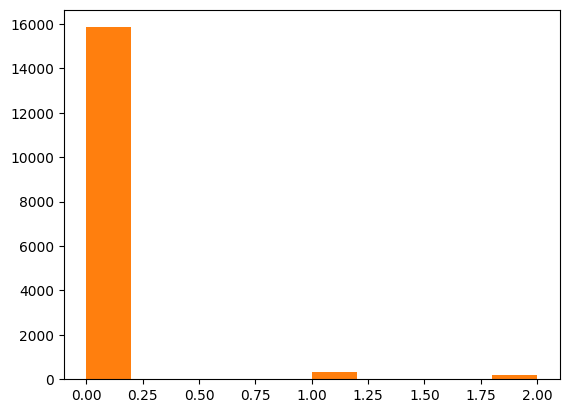

In [85]:
plt.hist(df_bma.nb_var_vif_above_5)
plt.show()

On peut décider ici de retirer tous les modèles avec des VIF > 5

En appliquant les deux règles (shapiro et VIF) alors on perd la moitié des sous-modèles. Ceci signifie que la moitié des sous-modèles ne respectent pas les hypothèses de normalité des résidus et de non-multi-collinéarité des variables

In [86]:
df_models_kept = df_bma[(df_bma.nb_var_vif_above_5 < 1 ) & (df_bma.pval_shapiro > 0.05)]
df_models_kept = df_models_kept.drop(['pval_shapiro', 'pval_kolmogorov', 'mean_resid', 'nb_var_vif_above_5'], axis=1)

In [87]:
np.shape(df_models_kept)

(12232, 38)

  Maintenant je garde les modèles qui respectent les hypothèses sur les pvalues des variables 

In [88]:
#ici je regarde juste l'occurence des variables, des sous modèles non colinéaires et aux résidus normaux

pval_cols = [col for col in df_models_kept.columns if col.endswith('_param')]

for col in pval_cols :

  print(col , ": Nombre de modèles sans cette variables :" , df_models_kept[col].isna().sum())

const_param : Nombre de modèles sans cette variables : 0
IRLT_ann_lag2_param : Nombre de modèles sans cette variables : 6087
RGDP_tri_lag5_param : Nombre de modèles sans cette variables : 6699
RREP_tri_param : Nombre de modèles sans cette variables : 6128
RREP_tri_lag1_param : Nombre de modèles sans cette variables : 5877
RREP_tri_lag2_param : Nombre de modèles sans cette variables : 6902
RREP_tri_lag3_param : Nombre de modèles sans cette variables : 6044
RREP_tri_lag4_param : Nombre de modèles sans cette variables : 6228
RREP_tri_lag5_param : Nombre de modèles sans cette variables : 5412
UNR_tri_param : Nombre de modèles sans cette variables : 6295
UNR_tri_lag1_param : Nombre de modèles sans cette variables : 6307
UNR_tri_lag3_param : Nombre de modèles sans cette variables : 5718
UNR_tri_lag4_param : Nombre de modèles sans cette variables : 6312
UNR_tri_lag5_param : Nombre de modèles sans cette variables : 6225
td_lag1_param : Nombre de modèles sans cette variables : 7525


In [89]:
# ici je regarde plus sérieusement la significativité des variables, et je drop tous les sous modèles avec des pvalues 
pval_cols = [col for col in df_models_kept.columns if col.endswith('_pval')]

for col in pval_cols :
    df_models_kept[col] = df_models_kept[col].fillna(-100) # ca facilite le mask juste après.

mask = (df_models_kept[pval_cols] < 0.05).all(axis=1)

df_significant = df_models_kept[mask]


In [91]:
df_significant.columns

Index(['variables', 'bic', 'logv', 'R2', 'R2_aj', 'RMSE', 'U de Theil',
       'boolean_anderson', 'nb_vars', 'const_param', 'IRLT_ann_lag2_param',
       'RGDP_tri_lag5_param', 'IRLT_ann_lag2_pval', 'RGDP_tri_lag5_pval',
       'RREP_tri_param', 'RREP_tri_pval', 'RREP_tri_lag1_param',
       'RREP_tri_lag1_pval', 'RREP_tri_lag2_param', 'RREP_tri_lag2_pval',
       'RREP_tri_lag3_param', 'RREP_tri_lag3_pval', 'RREP_tri_lag4_param',
       'RREP_tri_lag4_pval', 'RREP_tri_lag5_param', 'RREP_tri_lag5_pval',
       'UNR_tri_param', 'UNR_tri_pval', 'UNR_tri_lag1_param',
       'UNR_tri_lag1_pval', 'UNR_tri_lag3_param', 'UNR_tri_lag3_pval',
       'UNR_tri_lag4_param', 'UNR_tri_lag4_pval', 'UNR_tri_lag5_param',
       'UNR_tri_lag5_pval', 'td_lag1_param', 'td_lag1_pval'],
      dtype='object')

Maintenant que je n'ai gardé que les modèles qui respectent les hypothèses, je peux regarder quels modèles sont les plus performants : Avec le BIC je calcule la proba à posteriori. 

**Sélection des sous-modèles les plus performants et Proba à posteriori**

In [ ]:
df_sorted = df_significant.sort_values(by=['bic']) 
n = len(df_sorted) // 2 
df_filtered = df_sorted.head(n)
df_filtered


In [ ]:
# c'est équivalent au fait d'appliquer le SoftMax sur la colonne du BIC
df_filtered['prob_post_num'] = df_filtered['bic'].apply(lambda x: np.exp(-0.5 * x))
df_filtered['prob_posteriori'] = df_filtered['prob_post_num'].apply(lambda x: x/df_filtered['prob_post_num'].sum())

**Pondération des sous-modèles, contruction finale du modèle BMA et analyse des résultats de la modélisation**

In [ ]:

### Création du dataframe avec les colonnes que l'on garde car au moins un modèle admet un coefficient pour la variable & aussi on applique la pondération des coefficients par la probabilité a posteriori du modele. On fillna par 0 les colonnes vides
# filter out the columns that end with '_param'
param_cols = [col for col in df_filtered.columns if col.endswith('_param')]

# create a new dataframe with the filtered columns multiplied by 'prob_posteriori'
df_significant_param = df_filtered[param_cols].multiply(df_filtered['prob_posteriori'], axis=0)

# print the new dataframe
df_significant_param = df_significant_param.fillna(0)

### On drop les colonnes sans coefficients ; ce sont des variables non significatives ou qui n'expliquent pas la target.
# create a list of columns to drop
cols_to_drop = []

# loop through each column in the DataFrame
for col in df_significant_param.columns:
    # check if the column is filled with 0
    if df_significant_param[col].eq(0).all():
        cols_to_drop.append(col)

# drop the columns that are filled with 0
df_significant_param_no_0 = df_significant_param.drop(cols_to_drop, axis=1)

### Finalement on va sommer les colonnes, ca fait qu'on obtient dans chaque colonne le paramètre de la variable associée
# sum all the columns of the DataFrame
df_sum = df_significant_param_no_0.sum()

# convert the resulting series to a DataFrame with one row
df_row_parameters = pd.DataFrame(df_sum).transpose()

# Create a dictionary of old and new column names
rename_dict = {col: col.replace('_param', '') for col in df_row_parameters.columns}

# Rename the columns using the dictionary
df_row_parameters = df_row_parameters.rename(columns=rename_dict)

### Il faut utiliser les paramètres et les observations pour créer la série DRt estimée
#maintenant qu'on a les coefficients il faut les utiliser avec les observations pour calculer le DRt Estimé 
df_X = X.copy()

# Get the column names of df_X and df_row_parameters
X_cols = set(df_X.columns)
params_cols = set(df_row_parameters.columns)
#Attention : on perd la constance ici, ON DOIT LA RAJOUTER ENSUITE

# Find the common columns between the two sets
common_cols = list(X_cols.intersection(params_cols))

# Create a new DataFrame with only the common columns
df_X_common = df_X[common_cols]

# Convert the DataFrames to numpy arrays
X_observed = df_X_common.values
params = df_row_parameters[common_cols].values.reshape(-1, 1)

# Multiply X and params using matrix multiplication
pred_values = X_observed @ params 

# Adding the intercept...
pred_values_BMA = pred_values + df_row_parameters.const[0]


In [ ]:
df_pred = pd.DataFrame(pred_values_BMA, index=df_X.index, columns=['pred_values_BMA'])
y_obs = pd.DataFrame(y)
df_actual_and_predict = pd.merge(df_pred, y_obs, how='inner', left_index=True, right_index=True)


In [ ]:
x = df_actual_and_predict.index # Use the index as the x-axis
y_pred = df_actual_and_predict['pred_values_BMA'] # Get the predicted values
y_actual = df_actual_and_predict['td'] # Get the actual values

# Plot the predicted values and actual values as two separate lines
plt.plot(x, y_pred, label='Predicted "DRt estimé"')
plt.plot(x, y_actual, label='Actual "DRt"')

# Set the axis labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()


In [ ]:
coefficient_of_dermination_BMA = round(r2_score(y, pred_values_BMA), 4)
coefficient_of_dermination_BMA

In [ ]:
mean_squared_error_BMA = round(mean_squared_error(y, pred_values_BMA, squared=False), 4)
mean_squared_error_BMA

# Sans pondération : garder le meilleur modèle

Le modèle qui minimise le critère d'info <=> BIC

In [ ]:
row_with_lowest_bic = pd.DataFrame(df_significant.loc[df_significant['bic'].idxmin()]).T

row_with_lowest_bic

In [ ]:
def compute_y_estimated_from_model(df):

  # filter out the columns that end with '_param'
  param_cols = [col for col in df.columns if col.endswith('_param')]
  df = df[param_cols]
  # print the new dataframe
  df_significant_param = df.fillna(0)

  # create a list of columns to drop
  cols_to_drop = []

  # loop through each column in the DataFrame
  for col in df_significant_param.columns:
    # check if the column is filled with 0
    if df_significant_param[col].eq(0).all():
        cols_to_drop.append(col)
  df_row_parameters = df_significant_param.drop(cols_to_drop, axis=1)

  
  # Create a dictionary of old and new column names
  rename_dict = {col: col.replace('_param', '') for col in df_row_parameters.columns}

  # Rename the columns using the dictionary
  df_row_parameters = df_row_parameters.rename(columns=rename_dict)

  ### Il faut utiliser les paramètres et les observations pour créer la série DRt estimée
  #maintenant qu'on a les coefficients il faut les utiliser avec les observations pour calculer le DRt Estimé 
  df_X = X.copy()

  # Get the column names of df_X and df_row_parameters
  X_cols = set(df_X.columns)
  params_cols = set(df_row_parameters.columns)

  # Find the common columns between the two sets
  common_cols = list(X_cols.intersection(params_cols))

  # Create a new DataFrame with only the common columns
  df_X_common = df_X[common_cols]

  # Convert the DataFrames to numpy arrays
  X_observed = df_X_common.values
  params = df_row_parameters[common_cols].values.reshape(-1, 1)

  # Multiply X and params using matrix multiplication
  pred_values = X_observed @ params 
  
  df_row_parameters.reset_index(drop=True, inplace=True)

  # Adding the intercept...
  pred_values_model = pred_values + df_row_parameters.const[0]

  return pred_values_model

pred_values_model_bic = compute_y_estimated_from_model(row_with_lowest_bic)

In [ ]:
coefficient_of_dermination_best_bic = round(r2_score(y, pred_values_model_bic), 4)
coefficient_of_dermination_best_bic

In [ ]:
mean_squared_error_best_bic = round(mean_squared_error(y, pred_values_model_bic, squared=False), 4)
mean_squared_error_best_bic

**Le modèle qui maximise la vraisemblance**

In [ ]:
row_with_highest_LL = pd.DataFrame(df_significant.loc[df_significant['logv'].idxmax()]).T
row_with_highest_LL

In [ ]:
pred_values_model_LL = compute_y_estimated_from_model(row_with_highest_LL)

In [ ]:
coefficient_of_dermination_best_bic = round(r2_score(y, pred_values_model_LL), 4)
coefficient_of_dermination_best_bic

In [ ]:
mean_squared_error_best_LL = round(mean_squared_error(y, pred_values_model_LL, squared=False), 4)
mean_squared_error_best_LL